In [1]:
#Install required packages
%pip install -U langgraph langchain_community langchain_openai langsmith langgraph-supervisor 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Environment Variable Initialization

import getpass
import os

def _set_if_undefined(var_name: str):
    """
    Set an environment variable if it is not already defined.
    
    Args:
        var_name (str): Name of the environment variable to set.
    """
    if not os.environ.get(var_name):
        # Securely prompt the user for input without echoing it on screen
        os.environ[var_name] = getpass.getpass(f"Please provide your {var_name}: ")

# ---- Environment Variables Required ----

_set_if_undefined("OPENAI_API_KEY")         # API key for OpenAI models
_set_if_undefined("LANGSMITH_TRACING")      # Enable LangSmith tracing ("true" to enable)
_set_if_undefined("LANGSMITH_API_KEY")      # API key for LangSmith platform
_set_if_undefined("MODEL")                  # Model name (e.g., "gpt-4.1" "gpt-4o", "gpt-3.5-turbo")

In [3]:
from typing import Literal
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command

lifts= ["lift1", "lift2"]
floors= ["floor1","floor2","floor3","floor4","floor5"]
options= lifts + [END]

class OverallState(MessagesState):
   """The graph state with next step to execute."""
   currentstep : Literal["1", "2", "3", END]
   selectedlift : Literal[*lifts]   

class NextStep(TypedDict):
   """The graph state with next step to execute."""
   step : Literal["1", "2", "3", END]
   

class SelectedLift(TypedDict):
   """The graph state with the selected lift."""
   lift : Literal[*lifts]   

class LiftLocations(TypedDict):
   """Lift locations."""
   lift1loc : str  
   lift2loc : str


controller_system_prompt = (
  f"You are a lift controller managing a building with {floors.count} floors and {lifts.count} lifts." 
  " Each floor has a call button that summons a lift. "
  f"At any moment, the lifts are stationed at various floors (as represented by {lifts})." 
  "Your task is to choose the best available lift based on the distance between the requested floor and the current positions of the lifts."
  
  "When a floor requests a lift, perform the following steps according to the lift request handling process:"
  f"1. Send a message to all lifts ({lifts}) requesting their current locations."
  " 2. Receive and analyze the location responses from each lift."
  "    Calculate the distance between the calling floor and each lift's current floor. "
  "    Identify the closest lift (if there's a tie, use your internal tie-breaking rule)."
  " 3. Send a reserve message to the selected lift and rejection messages to all other lifts."

  "For example, consider a building with 5 floors and 2 lifts. Suppose the lifts are currently positioned as follows:"
  "  - Lift1: 1st floor"
  "  - Lift2: 5th floor"

  "If a request comes from the 2nd floor:"
  "- You first ask both lifts for their positions."
  "- The distances from the 2nd floor are:"
  "    - Lift1: |2 - 1| = 1 floor away"
  "    - Lift2: |2 - 5| = 3 floor away"
  "- Since lift1 is closer you send a reserve message to lift1."
  "- Reserve the chosen lift and send rejection messages to the other."
  "Now, given any new floor request, first ask for the location of all lifts, then identify and reserve the closest one." 
  "Here is the communication between lifts and controller so far: " 
)

llm = ChatOpenAI(model="gpt-4.1")

def lift_controller_node(state: OverallState) -> Command[Literal[*lifts, END]]:
    messages = [
        {"role": "system", "content": controller_system_prompt},
    ] + state["messages"] + [" Based on the messages history, and following the lift request handling process outlined above, What should be the next step to perform. If all steps are completed respond with -1."]
                             
    response = llm.with_structured_output(NextStep).invoke(messages)
    
    nextstep = response["step"]
    
    if(nextstep == "1"):
        print("************** step 1 ***************")
        return Command(goto=["lift1", "lift2"], 
        update={
                "messages": [
                             HumanMessage(content="CFP: Share your current location", name="lift_controller")
                            ],
                 "currentstep" : nextstep
                        })
    
    elif(nextstep == "2"):
        print("************** step 2 ***************")
        
        messages = [
            {"role": "system", "content": controller_system_prompt},
        ] + state["messages"] + [" Based on the messages history, identify lift1 and lift2 current location."]
    
        response = llm.with_structured_output(LiftLocations).invoke(messages)
    
        print("************** locations ***************")
        print(response)

        lift1loc = response["lift1loc"]
        lift2loc = response["lift2loc"]
        
        messages = state["messages"] + [f" Looking at the messages history and the users floor input identify which lift is closer to the user floor if lift1 and lift2 current locations are {lift1loc} and {lift2loc} respectively."]

        response = llm.invoke(messages)
        reasoning = response.content

        response = llm.with_structured_output(SelectedLift).invoke(messages)
    
        print("************** selected lift ***************")
        print(response)
    
        return Command(goto=["lift1", "lift2"], 
        update={
                "messages": [
                             HumanMessage(content=f"Reasoning: {reasoning} Selected lift: {response["lift"]}", name="lift_controller")
                            ],
                "currentstep" : nextstep
                        })

        

    elif(nextstep == "3"):
        print("************** step 3 ***************")

        response = llm.with_structured_output(SelectedLift).invoke(messages)
    
        return Command(goto=[response["lift"]], 
        update={
                "messages": [
                             HumanMessage(content=f"Selection: You ({response["lift"]}) are selected", name="lift_controller")
                            ],
                "currentstep" : nextstep
                        })

    
    print("************** END ***************")
    return Command(goto=END)
        

In [4]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START

def lift1_node(state: OverallState) -> Command[Literal["lift_controller"]]:
    
    if(state["currentstep"] == "1"):
        return Command(
            update={
                "messages": [
                    HumanMessage(content="1", name="lift1")
                ]
            },
            goto="lift_controller",
        )
    
    elif(state["currentstep"] == "2"):
        return Command(
            update={
                "messages": [
                    HumanMessage(content="Acknowledge", name="lift1")
                ]
            },
            goto="lift_controller",
        )

    elif(state["currentstep"] == "3"):
        return Command(
            update={
                "messages": [
                    HumanMessage(content="Moving to target floor", name="lift1")
                ]
            },
            goto="lift_controller",
        )


def lift2_node(state: OverallState) -> Command[Literal["lift_controller"]]:
    
    if(state["currentstep"] == "1"):
        return Command(
            update={
                "messages": [
                    HumanMessage(content="5", name="lift2")
                ]
            },
            goto="lift_controller",
        )
    
    elif(state["currentstep"] == "2"):
        return Command(
            update={
                "messages": [
                    HumanMessage(content="Acknowledge", name="lift2")
                ]
            },
            goto="lift_controller",
        )

    elif(state["currentstep"] == "3"):
        return Command(
            update={
                "messages": [
                    HumanMessage(content="Moving to target floor", name="lift2")
                ]
            },
            goto="lift_controller",
        )


builder = StateGraph(MessagesState)
builder.add_edge(START, "lift_controller")
builder.add_node("lift_controller", lift_controller_node)
builder.add_node("lift1", lift1_node)
builder.add_node("lift2", lift2_node)
graph = builder.compile()

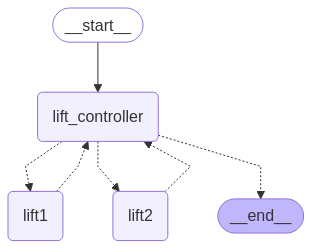

In [5]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
for s in graph.stream(
    {"messages": [("user", "floor 2")]}, subgraphs=True,debug=True):
    print(s)
    print("============================")

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user', 'floor 2')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'floor 2')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='floor 2', additional_kwargs={}, response_metadata={}, id='7f4de539-b70f-4081-bdc9-451e78471451')]}
[1:tasks] Starting 1 task for step 1:
- lift_controller -> {'messages': [HumanMessage(content='floor 2', additional_kwargs={}, response_metadata={}, id='7f4de539-b70f-4081-bdc9-451e78471451')]}
************** step 1 ***************
((), {'lift_controller': {'messages': [HumanMessage(content='CFP: Share your current location', additional_kwargs={}, response_metadata={}, name='lift_controller')], 'currentstep': '1'}})
[1:writes] Finished step 1 with writes to 2 channels:
- messages -> [HumanMessage(content='CFP: Share your current location', additional_kwargs={}, response_metad